**Age and Gender Detection System.**

In this project, we will be performing both classification and regression to predict both gender and age respectively.

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

Load the dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Projects/Age&GenderProject/UTKFace.zip'

Streaming output truncated to the last 5000 lines.
  inflating: UTKFace/53_0_1_20170116191725055.jpg.chip.jpg  
  inflating: UTKFace/53_0_1_20170116192938845.jpg.chip.jpg  
  inflating: UTKFace/53_0_1_20170117181950281.jpg.chip.jpg  
  inflating: UTKFace/53_0_1_20170120222553113.jpg.chip.jpg  
  inflating: UTKFace/53_0_1_20170120222956787.jpg.chip.jpg  
  inflating: UTKFace/53_0_1_20170120223004304.jpg.chip.jpg  
  inflating: UTKFace/53_0_2_20170104210010763.jpg.chip.jpg  
  inflating: UTKFace/53_0_2_20170112215433623.jpg.chip.jpg  
  inflating: UTKFace/53_0_2_20170112221930338.jpg.chip.jpg  
  inflating: UTKFace/53_0_2_20170116192925824.jpg.chip.jpg  
  inflating: UTKFace/53_0_2_20170116192934154.jpg.chip.jpg  
  inflating: UTKFace/53_0_2_20170119205816456.jpg.chip.jpg  
  inflating: UTKFace/53_0_3_20170104220848558.jpg.chip.jpg  
  inflating: UTKFace/53_0_3_20170109132854337.jpg.chip.jpg  
  inflating: UTKFace/53_0_3_20170109142546975.jpg.chip.jpg  
  inflating: UTKFace/53_0_3_201701

In [5]:
BASE_DIR = '/content/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [6]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [7]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [8]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/UTKFace/56_0_0_20170111200016066.jpg....,56,0
1,/content/UTKFace/2_0_3_20161220143054648.jpg.c...,2,0
2,/content/UTKFace/4_0_2_20161219160939189.jpg.c...,4,0
3,/content/UTKFace/22_1_4_20170103223216583.jpg....,22,1
4,/content/UTKFace/35_1_0_20170117022414604.jpg....,35,1


Exploratory Data Anlysis

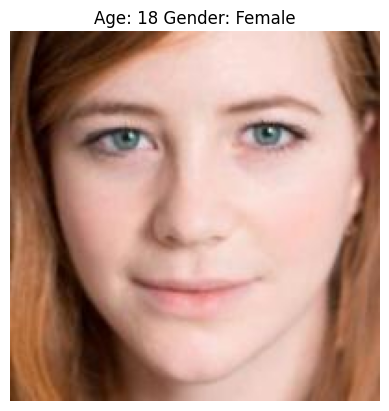

In [9]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

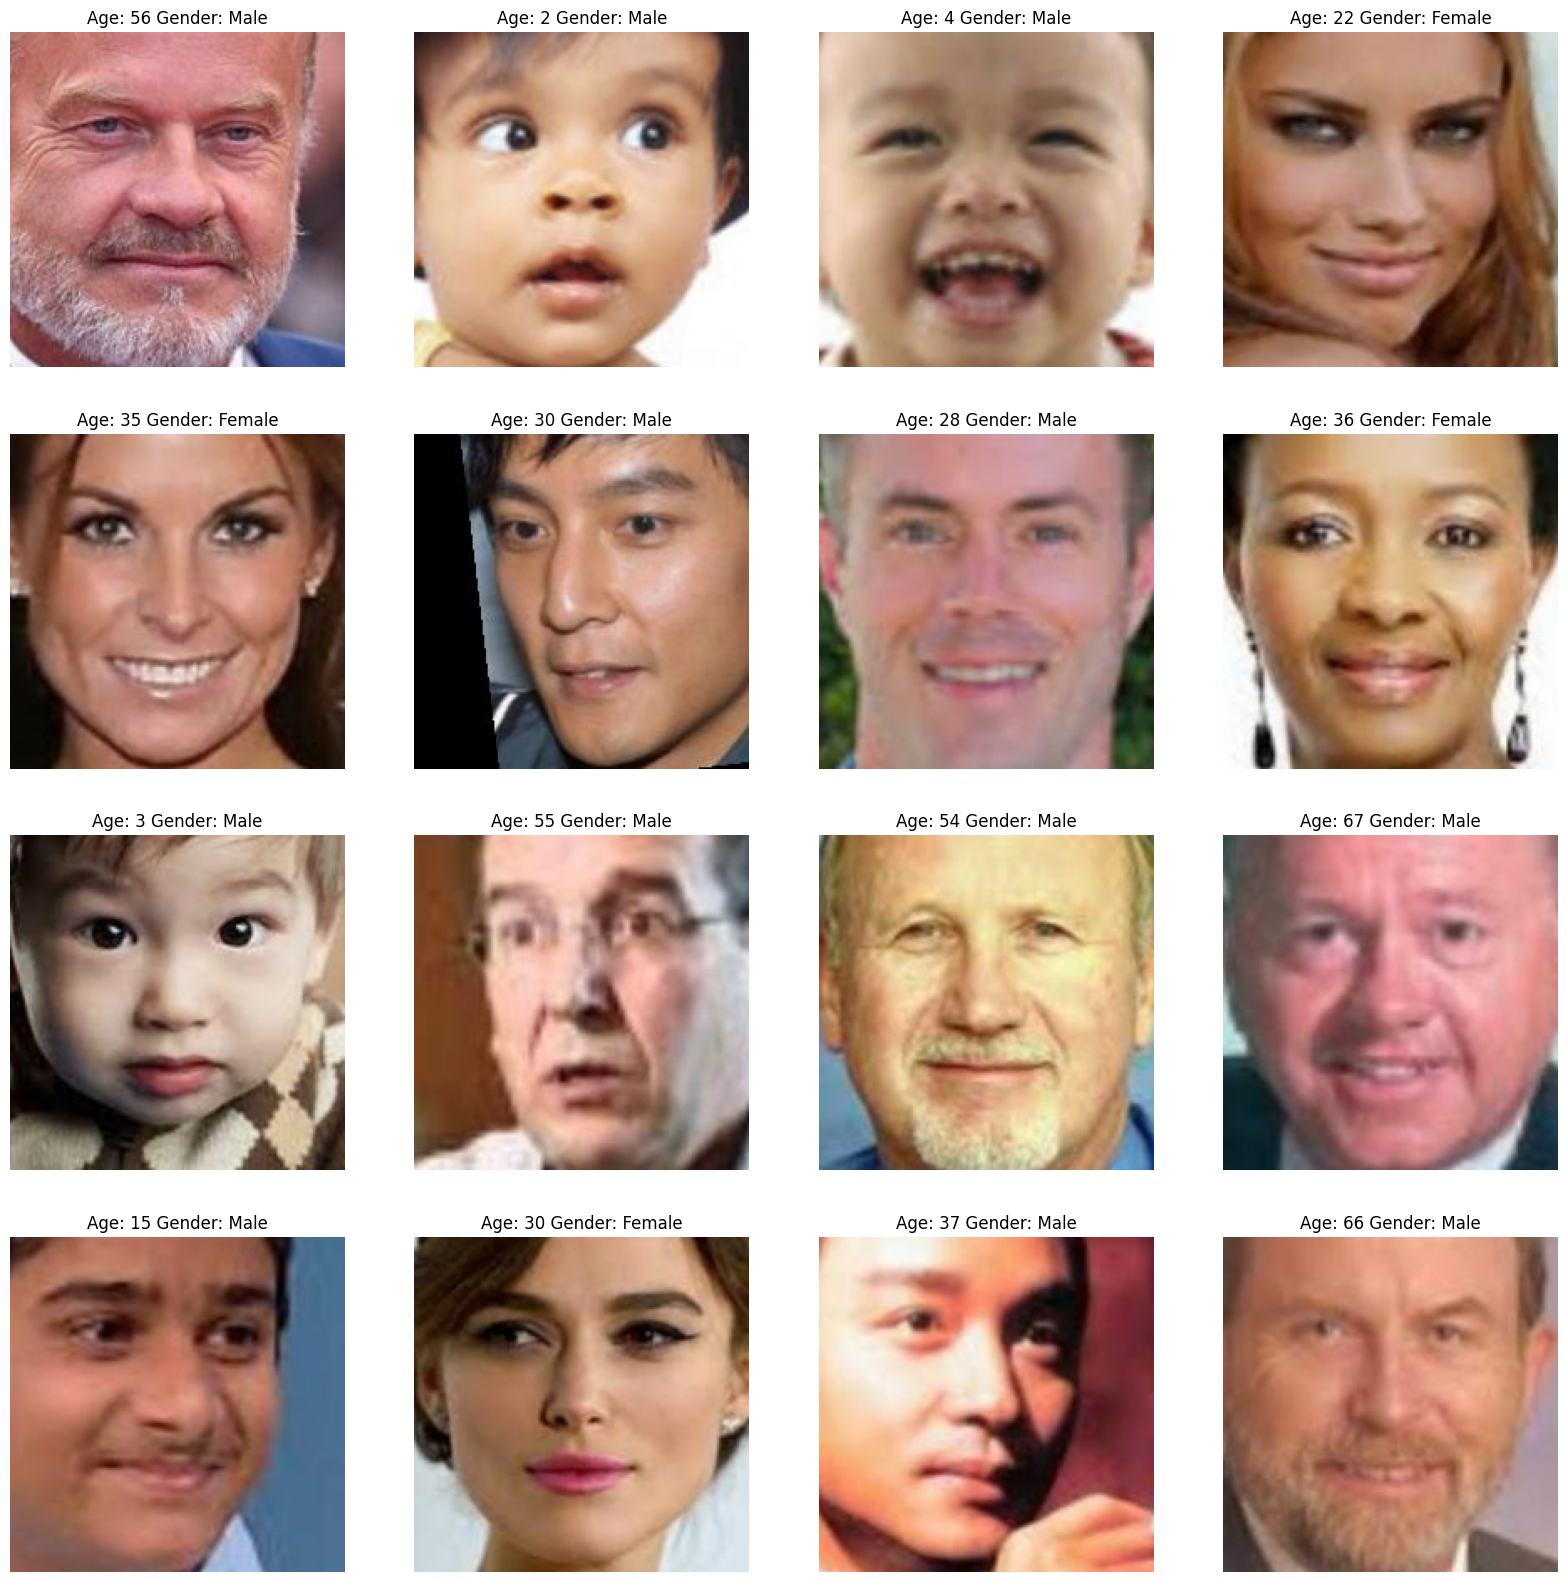

In [12]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

Feature Extraction

In [13]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, color_mode="grayscale")
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [14]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [15]:
X.shape

(23708, 128, 128, 1)

In [16]:
X = X / 255.0

In [17]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [18]:
input_shape = (128, 128, 1)

In [19]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss={'gender_out':'binary_crossentropy', 'age_out': 'mae'},
              optimizer='adam',
              metrics={'gender_out':'accuracy', 'age_out':'mae'})

In [21]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - age_out_mae: 16.4596 - gender_out_accuracy: 0.5242 - loss: 17.1719 - val_age_out_mae: 13.8805 - val_gender_out_accuracy: 0.7223 - val_loss: 14.4382
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_out_mae: 11.7425 - gender_out_accuracy: 0.7384 - loss: 12.2722 - val_age_out_mae: 11.6761 - val_gender_out_accuracy: 0.7954 - val_loss: 12.1103
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - age_out_mae: 9.7559 - gender_out_accuracy: 0.7908 - loss: 10.1983 - val_age_out_mae: 8.3282 - val_gender_out_accuracy: 0.8332 - val_loss: 8.7008
Epoch 4/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_out_mae: 8.5225 - gender_out_accuracy: 0.8281 - loss: 8.8971 - val_age_out_mae: 7.6508 - val_gender_out_accuracy: 0.7957 - val_loss: 8.0491
Epoch 5/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_out_mae: 7.8889 - gender_out_accuracy: 0.8473 - loss: 8.2228 - val_age_out_mae: 7.8564 - val_gender_out_accuracy: 0.8674 - val_loss

Predicting Test Data

In [24]:
def get_image_features(image):
  img = load_img(image, color_mode="grayscale")
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


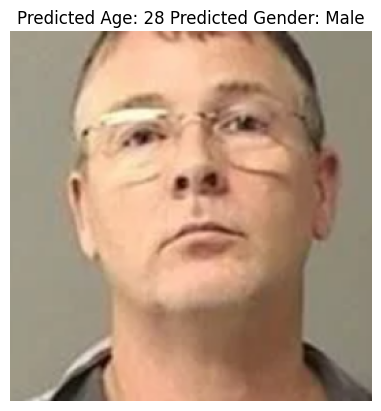

In [31]:
img_to_test = '/content/drive/MyDrive/Projects/Age&GenderProject/test images/1.png'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))